https://www.kaggle.com/chrisbss1/cramer-s-v-correlation-matrix  
https://github.com/yurkai/churn/blob/master/week07.ipynb  

In [100]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency

In [76]:
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

target_col = 'Churn'

In [75]:
test_data = pd.read_csv('./test.csv')
train_data = pd.read_csv('./train.csv')

,mean_diff,p_value
ClientPeriod,19.574321,1.509283e-155
TotalSpent,1038.002181,1.730280e-64
MonthlySpending,12.678458,4.243204e-37


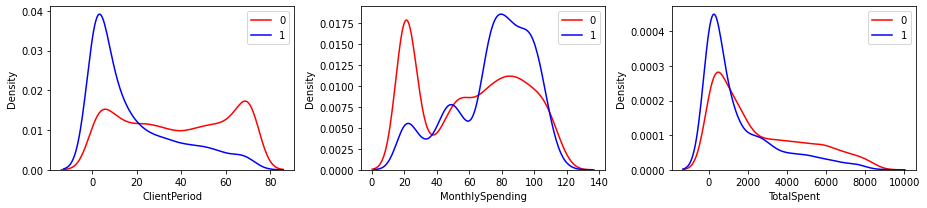

In [98]:
# Correlation between numeric features and categorical target
# Selecting numeric features based on difference in means of each class
# Mann-Whitney rank test for numeric features and categorical target variable
# Checking if our numeric features have signifficant difference in means (positive and negative class)
# All of our numeric features have significantly different means of each target class

def get_p_value(data, num_col, target_col):
    target = data[target_col]
    neg = data.loc[target == 0, num_col].dropna()
    pos = data.loc[target == 1, num_col].dropna()
    if len(neg) < 10 or len(pos) < 10: return 1
    return stats.mannwhitneyu(neg, pos)[1]

def show_significant_features(data, num_cols, target_col):
    target = data[target_col]
    means_neg = data.loc[target == 0, num_cols].mean()
    means_pos = data.loc[target == 1, num_cols].mean()
    mean_diff = np.abs(means_pos - means_neg)
    p_values = [get_p_value(data, col, target_col) for col in num_cols]
    df = pd.DataFrame({'mean_diff': mean_diff, 'p_value': p_values})
    display(df[df['p_value'] < 0.01].sort_values('p_value'))

def show_density_distribution(data, num_cols, target_col):
    target = data[target_col]
    fig, axes = plt.subplots(1, 3, figsize=(13, 3))
    for c, ax in zip(num_cols, axes.flat):
        sns.kdeplot(data.loc[target == 0, c], color='r', ax=ax, label=0)
        sns.kdeplot(data.loc[target == 1, c], color='b', ax=ax, label=1)
        ax.set_xlabel(c); ax.legend();
    fig.tight_layout()

data = train_data.copy()
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')

show_significant_features(data, num_cols, target_col)
show_density_distribution(data, num_cols, target_col)

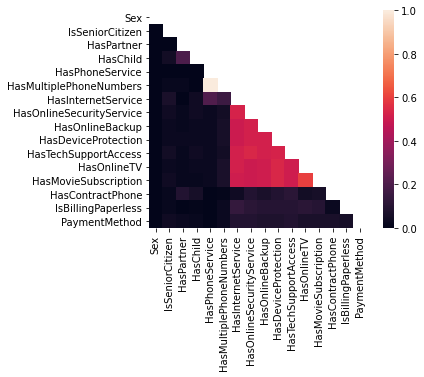

In [99]:
# Correlation between categorical features (Cramer's V)

def cramers_V(v1, v2):
    crosstab = np.array(pd.crosstab(v1, v2))
    stat = chi2_contingency(crosstab)[0]
    obs = np.sum(crosstab)
    mini = min(crosstab.shape) - 1
    return (stat / (obs * mini))

def show_cat_correlation_matrix(data, cat_cols):
    label = LabelEncoder()
    data_encoded = pd.DataFrame()
    for c in cat_cols: 
        data_encoded[c] = label.fit_transform(data[c])
    rows = []
    for v1 in data_encoded:
        col = []
        for v2 in data_encoded:
            cramers =cramers_V(data_encoded[v1], data_encoded[v2])
            col.append(round(cramers, 2))
        rows.append(col)
    cramers_results = np.array(rows)
    df = pd.DataFrame(cramers_results, columns=data_encoded.columns, index=data_encoded.columns)
    mask = np.zeros_like(df, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(df, mask=mask, vmin=0., vmax=1, square=True)

show_cat_correlation_matrix(data, cat_cols)

In [156]:
def get_target_ranks(data, cat_cols, target_col):
    # for c in cat_cols: data[c] = data[c].map(target_ranks[c])
    return {c: data.groupby(c)[target_col].mean().to_dict() for c in cat_cols}

def map_target_ranks(data, cat_cols, target_ranks):
    return data[cat_cols].apply(lambda x: x.map(target_ranks[x.name]))

data = train_data.copy()
target_ranks = get_target_ranks(data, cat_cols, target_col)
data[cat_cols] = map_target_ranks(data, cat_cols, target_ranks)

In [ ]:
# LogisticRegression (new)

def get_target_rates(data, cat_cols, target_col):
    return {c: data.groupby(c)[target_col].mean().to_dict() for c in cat_cols}

def map_target_ranks(data, cat_cols, target_ranks):
    return data[cat_cols].apply(lambda x: x.map(target_ranks[x.name]))

def prepare_data(data, train=False):
    
    data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce').fillna(0)
    
    if train: # dropping zeros and outliers
        data = data[data['ClientPeriod'] != 0].copy()
        data = data[((data['ClientPeriod'] <= 69.5) & (data['Churn'] == 1) | (data['Churn'] == 0))].copy()
    
    else: # test: replacing zeros with median
        replace_zeros = lambda x: x.replace(0, x.median())
        data['ClientPeriod'] = data.groupby('HasContractPhone')['ClientPeriod'].apply(replace_zeros)
    
    monthly_spending_bins = np.arange(17.5,125,5)
    client_period_bins = [-1,0,2,5,10,17,25,33,43,53,62,70,72,100]
    data['MonthlySpending'] = pd.cut(data['MonthlySpending'], bins=monthly_spending_bins).astype(str)
    data['ClientPeriod'] = pd.cut(data['ClientPeriod'], bins=client_period_bins).astype(str)
    
    if train:
        target_ranks = get_target_ranks(data, cat_cols + ['ClientPeriod','MonthlySpending'], target_col)
    
    data[cat_cols + ['ClientPeriod','MonthlySpending']] = map_target_ranks(data, cat_cols, target_ranks)

    return data

test_data = prepare_data(pd.read_csv('./test.csv'), train=False)

train_data = prepare_data(pd.read_csv('./train.csv'), train=True)
target_ranks = get_target_ranks(train_data, cat_cols + ['ClientPeriod','MonthlySpending'], target_col)


num_cols_ = [] 
cat_cols_ = ['ClientPeriodG','MonthlySpendingG'] 

preprocessor = ColumnTransformer([('0', OneHotEncoder(handle_unknown='ignore'), cat_cols_)])
classifier = LogisticRegression(C=1, penalty='l1', solver='liblinear')
model = Pipeline([('pre', preprocessor), ('clf', classifier)])
shuffle = StratifiedKFold(n_splits=30, shuffle=True, random_state=42)
s = cross_val_score(model, train_data[cat_cols_ + num_cols_], train_data[target_col], scoring='roc_auc', cv=shuffle)
print(f'roc_auc: {s.mean():.4f} (mean), {s.std():.4f} (std)')
print(f'scores: {s}')

model.fit(train_data[cat_cols_ + num_cols_], train_data[target_col])
submission = pd.read_csv('./submission.csv')
submission['Churn'] = model.predict_proba(test_data[cat_cols_ + num_cols_])[:,1]
submission.to_csv('./my_submission.csv', index=False)

c = np.abs(model['clf'].coef_)
print(f'coef_: {c.min():.3f} (min), {c.max():.3f} (max), {(c==0).sum()} / {len(c[0])} (zeros)')